In [1]:
from Topic_Models.topic_model import Topic_Model
import pandas as pd
from flask_app.classifier import Active_Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from Topic_Models.Neural_Topic_Model import Neural_Model
import pickle
from multiprocessing import Process, Manager
import copy
from scipy.sparse import csr_matrix
import numpy as np

In [2]:
doc_dir = './Topic_Models/Data/congressional_bill_train.json'
processed_doc_dir = './Topic_Models/Data/congressional_bill_train_processed.pkl'

'''
Mapping the mode numbers to which model we use
LA: active learning baseline
'''
model_types_map = {0: 'LA' , 1: 'LDA', 2: 'SLDA', 3: 'ETM'}
num_iter = 3000
load_data = True
save_model = False

'''
Enter the number of topics for the model you just trained
'''
num_topics =13
inference_alg = 'logreg'
test_dataset_name = './Topic_Models/Data/congressional_bill_test.json'

'''
Keep those and don't change
'''
USE_TEST_DATA = True
USE_PROCESSED_TEXT = False
CONCATENATE_KEYWORDS = True
table = pd.read_json(doc_dir)
training_length = len(table)
REGRESSOR_PREDICT = True
mode = 1

In [3]:
model = Topic_Model(num_topics, 0, model_types_map[mode], processed_doc_dir, training_length, {}, True, './Topic_Models/Model/{}_{}.pkl'.format(model_types_map[mode], num_topics))
# model = Neural_Model('./Model/ETM_{}.pkl'.format(num_topics), processed_doc_dir, doc_dir)

In [4]:
from flask_app.utils.tools import find_doc_for_TA
import numpy as np

In [5]:
document_probas = model.document_probas

In [6]:
def count_docs(dictionary):
    result = 0
    for k, v in dictionary.items():
        result += len(v)

    return result

def update_median_prob(topic_num, idx_in_topic, doc_probs):
        try:
            doc_probs[topic_num].pop(idx_in_topic)
        except:
            doc_probs.pop(topic_num)

def print_topic_lens(dictionary):
    for k, v in dictionary.items():
        print('topic {} num docs {}'.format(k, len(v)))

In [7]:
%%capture
print('total num docs', count_docs(document_probas))

recommended_docs = []
recommended_topics = []
# Since the length of the document probas change, np.ones length should also change
for i in range(100):
    chosen_idx, chosen_topic, chosen_idx_in_topic = find_doc_for_TA(document_probas, np.ones(training_length))
    update_median_prob(chosen_topic, chosen_idx_in_topic, document_probas)
    # print_topic_lens(document_probas)
    print('doc id is ', chosen_idx)
    # chosen_topic
    recommended_topics.append(chosen_topic)
    recommended_docs.append(chosen_idx)

In [8]:
from collections import Counter
Counter(recommended_topics)

Counter({5: 41, 6: 31, 7: 28})

In [9]:
import numpy as np
def save_results(lst, file_name):
    np.save(file_name, lst)

In [16]:
def calculate_activelearning_diversity(process=False, unigram=False):
    accs, purity, ri, nmi = [], [], [], []
    test_accs, test_purity, test_ri, test_nmi = [], [], [], []
    test_df = pd.read_json(test_dataset_name)
    # print('test length is', len(test_df))

   
    df = pd.read_json(doc_dir)
    labels = df.sub_labels.values.tolist()

    raw_texts = df.text.values.tolist()[0:training_length]
    test_texts = test_df.text.values.tolist()
    raw_texts.extend(test_texts)

    if unigram == True:
        vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1, 1))
    else:
        vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1, 2))
    
    if not process:
        vectorizer_idf = vectorizer.fit_transform(raw_texts)
    else:
        pickle_test = test_dataset_name.replace('.json', '_processed.pkl')
        with open(pickle_test, 'rb') as inp:
            loaded_test_data = pickle.load(inp)
            processed_test_data = loaded_test_data['datawords_nonstop']
            
        with open(processed_doc_dir, 'rb') as inp:
            loaded_train_data = pickle.load(inp)
            processed_train_data = loaded_train_data['datawords_nonstop']

        processed_train_data.extend(processed_test_data)

        text_data = [' '.join(doc) for doc in processed_train_data]
        # from sklearn.feature_extraction.text import CountVectorizer
        # vectorizer = CountVectorizer(binary=True)
        vectorizer_idf = vectorizer.fit_transform(text_data)



    alto = Active_Learning(raw_texts, None,  None, df, inference_alg, vectorizer_idf, training_length, 0, test_df)

    recommended_docs1 = []
    recommended_topics1 = []
    scores = []
    for i in range(100):
        recommend_id, score = alto.recommend_document(True)
        
        alto.label(recommend_id, labels[recommend_id])
        recommended_docs1.append(recommend_id)
        recommended_topics1.append(alto.last_recommended_topic)
        scores.append(score)
        print(raw_texts[recommend_id])
        # print(alto.user_labels)
        if len(alto.classes) >= 3:
            train_acc, b, p, r, n, e, f, g = alto.eval_classifier()
            accs.append(train_acc)
            purity.append(p)
            ri.append(r)
            nmi.append(n)
            test_accs.append(b)
            test_purity.append(e)
            test_ri.append(f)
            test_nmi.append(g)
        
    return accs, purity, ri, nmi, test_accs, test_purity, test_ri , test_nmi

In [11]:
def calculate_topic_diversity(module, concat):
    # accs, purity, ri, nmi = [-1], [-1], [-1], [-1]
    # test_accs, test_purity, test_ri, test_nmi = [-1], [-1], [-1], [-1]
    accs, purity, ri, nmi = [], [], [], []
    test_accs, test_purity, test_ri, test_nmi = [], [], [], []
    test_df = pd.read_json(test_dataset_name)
    # print('test length is', len(test_df))

    if module == 3:
        model = Neural_Model('./Topic_Models/Model/ETM_{}.pkl'.format(num_topics), processed_doc_dir, doc_dir)
    else:
        model = Topic_Model(num_topics, 0, model_types_map[module], processed_doc_dir, training_length, {}, True, './Topic_Models//Model/{}_{}.pkl'.format(model_types_map[module], num_topics))
    df = pd.read_json(doc_dir)
    labels = df.sub_labels.values.tolist()
    raw_texts = df.text.values.tolist()[0:training_length]
    document_probas, doc_topic_probas = model.group_docs_to_topics()
    topics = model.print_topics(verbose=False)
    vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,2))
    
    test_texts = test_df.text.values.tolist()
    if concat == True:
        # model_concate_texts = model.concatenate_keywords_raw(topics, raw_texts)
        vectorizer_idf = vectorizer.fit_transform(raw_texts)

        # print('before vactorizer ', np.shape(vectorizer_idf.toarray()))

        '''
        concatenate the features from topic model with the classifier
        '''
        concatenated_features = model.concatenate_features(vectorizer_idf.toarray())

        # print('after concatenation', np.shape(concatenated_features))

        # # return 1, 1, 1, 1, 1, 1, 1, 1, 1
        sparse_matrix = csr_matrix(concatenated_features, dtype=np.float64)

        vectorizer_idf = sparse_matrix
    else:
        model_concate_texts = raw_texts
        model_concate_texts.extend(test_texts)
        vectorizer_idf = vectorizer.fit_transform(model_concate_texts)
    
    

    alto = Active_Learning(raw_texts, copy.deepcopy(document_probas), doc_topic_probas, df, inference_alg, vectorizer_idf, training_length, 1, test_df)

    recommended_docs1 = []
    recommended_topics1 = []
    scores = []
    for i in range(100):

        '''
        If comment out the if else conditions, the performance of topic model wouldn't
        work well becuase the medium of probabilities within each topic are uneven
        '''
        if i <= 65:
            for j in range(30):
                recommend_id, score = alto.recommend_document(True)
        else:
            for j in range(15):
                recommend_id, score = alto.recommend_document(True)
        # recommend_id, score = alto.recommend_document(True)
        # if len(recommended_topics1) == 0:
        #     recommend_id, score = alto.recommend_document(True)
        # else:
        #     recommend_id, score = alto.recommend_document(True)
        #     iters = 0
        #     while recommended_topics1[-1] == alto.last_recommended_topic:
        #         recommend_id, score = alto.recommend_document(True)
        #         iters += 1
        #     print('{} iterations'.format(iters))
        
    
        alto.label(recommend_id, labels[recommend_id])
        recommended_docs1.append(recommend_id)
        recommended_topics1.append(alto.last_recommended_topic)
        scores.append(score)
        print(raw_texts[recommend_id])
        # print(alto.user_labels)
        if len(alto.classes) >= 3:
            train_acc, b, p, r, n, e, f, g = alto.eval_classifier()
            accs.append(train_acc)
            purity.append(p)
            ri.append(r)
            nmi.append(n)
            test_accs.append(b)
            test_purity.append(e)
            test_ri.append(f)
            test_nmi.append(g)
        
        if module == 2 and i != 0 and i % 25 == 0:
            model = Topic_Model(num_topics, num_iter, model_types_map[module], processed_doc_dir, training_length, alto.user_labels, False, None)
            model.train('./Topic_Models//Model/SLDA_test.pkl')
            model = Topic_Model(num_topics, 0, model_types_map[module], processed_doc_dir, training_length, {}, True, './Topic_Models//Model/SLDA_test.pkl')
            document_probas, doc_topic_probas = model.group_docs_to_topics()    
            alto.update_doc_probs(copy.deepcopy(document_probas), doc_topic_probas)       


    return recommended_topics1, accs, purity, ri, nmi, test_accs, test_purity, test_ri , test_nmi

In [12]:
recommended_topics1, a1, p1, r1, n1, ta1, tp1, tr1, tn1 = calculate_topic_diversity(1, True)
len(a1)

max topic index is  6
max median topic is  6
all recommended ids
{4800}
[]
To authorize the Secretary of the Interior to construct and to provide for operation and maintenance of the peripheral canal unit of the Delta division and to construct, operate, and maintain the Kellog unit of the Delta division of the Central. Valley project, California, and for other purposes
max topic index is  6
max median topic is  6
all recommended ids
{4800, 10720}
['Water Resources Development']
To reauthorize the consent of Congress to the Northeast Interstate Dairy Compact and to grant the consent of Congress to the Southern Dairy Compact, a Pacific Northwest Dairy Compact, and an Intermountain Dairy Compact.
max topic index is  7
max median topic is  7
all recommended ids
{4800, 10720, 6576}
['Water Resources Development', 'Government Subsidies to Farmers and Ranchers, Agricultural Disaster Insurance']
To protect domestic consumers against an inadequate supply of soybeans and soybean products, to mai

98

In [13]:
recommended_topics2, a2, p2, r2, n2, ta2, tp2, tr2, tn2 = calculate_topic_diversity(2, True)
len(a2)

max topic index is  6
max median topic is  6
all recommended ids
{2828}
[]
A bill to redesignate the Black Canyon of the Gunnison National Monument as a national park, to establish the Gunnison Gorge National Conservation Area, to establish the Curecanti National Recreation Area, to establish the Black Canyon of the Gunnison National Park Complex, and for other purposes.
max topic index is  6
max median topic is  6
all recommended ids
{2828, 3543}
['National Parks, Memorials and Recreation']
num docs labeled 2
To designate certain public land as wilderness and certain rivers as wild and scenic rivers in the State of California, to designate Salmon Restoration Areas, to establish the Sacramento River National Recreation Area and Ancient Bristlecone Pine Forest, and for other purposes.
max topic index is  6
max median topic is  6
all recommended ids
{2828, 661, 3543}
['National Parks, Memorials and Recreation']
To authorize the negotiation, approval, and ratification of separate settleme

95

In [14]:
recommended_topics3, a3, p3, r3, n3, ta3, tp3, tr3, tn3 = calculate_topic_diversity(3, True)
len(a3)

max topic index is  8
max median topic is  8
all recommended ids
{4511}
[]
A bill to amend Title V of the Housing Act of 1949 to establish a Rural Housing Block Grant and for other purposes.
max topic index is  8
max median topic is  8
all recommended ids
{471, 4511}
['Rural Housing']
To provide for the development of model State laws providing reinsurance mechanisms for high-risk individuals and small employers.
max topic index is  8
max median topic is  8
all recommended ids
{471, 11717, 4511}
['Rural Housing', 'Health Insurance']
A bill to make improvements in the Black Lung Benefits Act, and for other purposes.
[[324 387 401]
 [290 302 312]
 [170 731 113]
 [345 416 339]
 [379 353 382]
 [286 426 404]
 [358 435 357]
 [370 328 410]
 [344 399 352]
 [361 312 378]
 [458 257 427]
 [330 425 380]]
train acc 0.009968560693198375; purity 0.12391687754006595; RI 0.6404358975444598; NMI 0.01585381971766288
test acc -1; purity -1; RI -1; NMI -1
max topic index is  8
max median topic is  8
all re

98

In [17]:
a4, p4, r4, n4, ta4, tp4, tr4, tn4 = calculate_activelearning_diversity(False, True)
a5, p5, r5, n5, ta5, tp5, tr5, tn5 = calculate_activelearning_diversity(False, False)

[]
To grant recognition for wartime service in the United States merchant marine and to provide that persons who served in the wartime merchant marine shall not be liable for induction into the armed services under the Selective Service Act of 1948
['Maritime Issues, Including Safety and Security']
A bill to provide for repositories for the disposal of high-level radioactive waste, transuranic waste, and spent nuclear fuel, to amend provisions of the Atomic Energy Act of 1954 relating to low-level waste, to modify the Price-Anderson provisions of the Atomic Energy Act of 1954 and certain other provisions pertaining to facility licensing and safety, and for other purposes.
Classifier in progess...
Score of the current document is 0.693147180559937
['Maritime Issues, Including Safety and Security', 'Hazardous Waste and Toxic Chemical Regulation, Treatment, and Disposal']
A bill to authorize a study of the feasibility and desirability of establishing a national recreation area to be known

In [18]:
import matplotlib.pyplot as plt

def plot_two_lists(x_label, y_label, legend_names, list1, list2):

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the first list with a blue line and label
    ax.plot(list1, label=legend_names[0], color='blue')

    # Plot the second list with a red line and label
    ax.plot(list2, label=legend_names[1], color='red')

    # Set the x and y labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Show the legend
    ax.legend()

    # Show the plot
    plt.show()

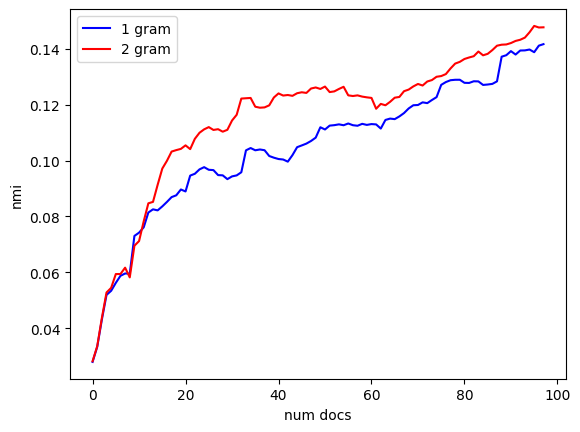

In [19]:
plot_two_lists('num docs', 'nmi', ['1 gram', '2 gram'], n4, n5)

In [21]:
# 2500, 25, Counter({4: 38, 24: 34, 23: 17, 1: 10, 22: 1})
# 3000, 25 , Counter({11: 33, 1: 28, 9: 18, 13: 9, 0: 6, 17: 4, 10: 2})

'''
Look at the distribution of number of documents recommended for each topic.
Generally, we want as many different topics recommended as possible
'''
print(Counter(recommended_topics1))
print(Counter(recommended_topics2))
print(Counter(recommended_topics3))

Counter({7: 28, 6: 25, 5: 24, 8: 22, 2: 1})
Counter({6: 37, 0: 16, 2: 15, 4: 12, 12: 12, 5: 8})
Counter({8: 100})


In [22]:
'''
First need to make all arrays the same length, then save it
'''

result_lst = [[a1, p1, r1, n1, ta1, tp1, tr1, tn1],
              [a2, p2, r2, n2, ta2, tp2, tr2, tn2],
              [a3, p3, r3, n3, ta3, tp3, tr3, tn3],
              [a4, p4, r4, n4, ta4, tp4, tr4, tn4]]
save_results(result_lst, './model_testing_results/13_topics_3000_no_concat.npy')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4, 8) + inhomogeneous part.

### Fetch word priors from the topic model. Possibly can be used as features for the classifier

In [14]:
from topic_model import Topic_Model
full_len = len(pd.read_json('./Data/congressional_bill_train.json'))
Model = Topic_Model(13, 2500, 'LDA', './Data/congressional_bill_train_processed.pkl', full_len , {}, False, None)
save_path = './Model/{}_{}.pkl'.format('LDA', 13)
Model.train(save_path)

num topics: 13
Created LDA model
starting training...


Iteration: 0, Log-likelihood: -8.406636824882892, Perplexity: 4476.679308942129, coherence: -3.5509948592368
Iteration: 500, Log-likelihood: -7.475815073969652, Perplexity: 1764.8395769139497, coherence: -3.7511233821533314
Iteration: 1000, Log-likelihood: -7.462803158437986, Perplexity: 1742.0243899572295, coherence: -3.7145287837997993
Iteration: 1500, Log-likelihood: -7.464387792713924, Perplexity: 1744.787049839745, coherence: -3.69925384010081
Iteration: 2000, Log-likelihood: -7.46392402801932, Perplexity: 1743.9780668098097, coherence: -3.652650521456323
-3.608885946530332
(13041, 13)
9306
9306


In [27]:
len(Model.model.used_vocabs)

9306

In [28]:
Model.model.used_vocabs

['program', 'united', 'national', 'establish', 'authorize', 'code', 'section', 'title', 'public', 'state', 'health', 'service', 'require', 'housing', 'secretary', 'development', 'relate', 'energy', 'assistance', 'education', 'tax', 'use', 'increase', 'law', 'grant', 'income', 'year', 'revenue', 'improve', 'respect', 'extend', 'land', 'fund', 'individual', 'security', 'internal', 'system', 'prohibit', 'provision', 'department', 'loan', 'control', 'water', 'school', 'commission', 'amend', 'care', 'agency', 'project', 'area', 'facility', 'agricultural', 'research', 'benefit', 'provide', 'construction', 'local', 'person', 'government', 'protection', 'promote', 'transportation', 'labor', 'employee', 'administration', 'authority', 'additional', 'conservation', 'protect', 'permit', 'assist', 'employment', 'shall', 'commerce', 'payment', 'safety', 'community', 'establishment', 'new', 'insurance', 'appropriation', 'drug', 'right', 'requirement', 'child', 'order', 'information', 'interstate', 'd

In [31]:
for word in Model.model.used_vocabs:
    prior = Model.model.get_word_prior(word)
    if len(prior) > 0:
        print(word)

In [34]:
Model.model.tw

0

In [4]:
model_vocabs = set()
for i in Model.data_words_nonstop:
    for j in i:
        model_vocabs.add(j)

len(model_vocabs)

9306

In [38]:
from gensim import corpora, models

# Example corpus of documents (list of lists of tokens)
with open('./Data/congressional_bill_train_processed.pkl', 'rb') as inp:
    data = pickle.load(inp)
    corpus = data['datawords_nonstop']

# Create a dictionary from the corpus
dictionary = corpora.Dictionary(corpus)

# Create a bag-of-words representation of the corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]

# Train an LDA model on the bag-of-words corpus
lda_model = models.LdaModel(bow_corpus, num_topics=13, id2word=dictionary, passes=10)



Word Prior Probability for 'college': 0.0000


In [45]:
def get_prior(target_word):
    # The word for which you want to get the word prior probability
    # target_word = "veteran"

    # Get the word prior probability for the target word
    word_id = dictionary.token2id[target_word]
    word_prior_prob = sum(prob for _, prob in lda_model.get_term_topics(word_id))

    print(f"Word Prior Probability for '{target_word}': {word_prior_prob:.4f}")

In [46]:
for word in corpus[0]:
    get_prior(word)

Word Prior Probability for 'authorize': 0.0886
Word Prior Probability for 'study': 0.0000
Word Prior Probability for 'feasibility': 0.0000
Word Prior Probability for 'desirability': 0.0000
Word Prior Probability for 'establish': 0.0602
Word Prior Probability for 'national': 0.0994
Word Prior Probability for 'recreation': 0.0000
Word Prior Probability for 'area': 0.0113
Word Prior Probability for 'know': 0.0000
Word Prior Probability for 'santa': 0.0000
Word Prior Probability for 'margarita': 0.0000
Word Prior Probability for 'national': 0.0994
Word Prior Probability for 'recreation': 0.0000
Word Prior Probability for 'area': 0.0113
Word Prior Probability for 'area': 0.0113
Word Prior Probability for 'san': 0.0000
Word Prior Probability for 'diego': 0.0000
Word Prior Probability for 'county': 0.0145
Word Prior Probability for 'calif': 0.0000
Word Prior Probability for 'presently': 0.0000
Word Prior Probability for 'constitute': 0.0000
Word Prior Probability for 'camp': 0.0000
Word Prior